# Introduction

Author: Harneet Rishi

Purpose: Figures and analysis of gene product features on time-series gene classification (Supp Fig 8)

# Imports

## Modules/packages

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.patches as patches

import statsmodels.stats.multitest as smm
from scipy.stats import hypergeom
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu
from scipy.stats import sem
from scipy.stats import kruskal

import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def calc_pooled_var(n1, var1, n2, var2):
    pooled_var = np.sqrt( ((n1 - 1)*var1 + (n2-1)*var2) / (n1 + n2 - 2) )
    return pooled_var

In [3]:
def calc_cohens_d(mean_x, mean_y, pooled_var):
    cohens_d = (mean_x - mean_y) / pooled_var
    return abs(cohens_d)

In [4]:
def calc_replichore(pos):
    if ((pos > 3923998) or (pos < 1588774)):
        rep = 1
    elif ((pos > 1588774) and (pos < 3923998)): 
        rep = 2 #(pos > 1588774 and < 3923998)
    return rep

In [5]:
def calc_dist_to_ori(rep,pos):
    dist_oriC_origin = 4641652 - 3923998 #717654
    pos_ori = 3923998
    if rep == 1:
        if pos > 3923998:
            dist_to_ori = pos - pos_ori
        elif pos < 1588774:
            dist_to_ori = dist_oriC_origin + pos
    elif rep == 2:
        if ((pos > 1588774) and (pos < 3923998)):
            dist_to_ori = pos_ori - pos
    return dist_to_ori

## Data

### sgRNA annotations

In [6]:
df_sgRNA_info_update_3 = pd.read_csv('SourceData/APAHR007_v4_21-df_sgRNA_info_update_3.csv')
df_sgRNA_info_update_3.drop(labels = 'seq.1', inplace = True, axis = 1)
df_sgRNA_info_update_3.set_index(keys = 'seq', inplace = True, drop = False)
df_sgRNA_info_update_3.head()

,seq,pos,strand,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
seq,,,,,,,,
agcggtaaaattcgtgtaat,agcggtaaaattcgtgtaat,923423,+,Promoter,,NaN,NaN,0
gcgagaaaccttattaacca,gcgagaaaccttattaacca,100609,+,Promoter,,NaN,NaN,0
ggcgtgccgatgggctacgg,ggcgtgccgatgggctacgg,3046225,-,Promoter,,NaN,NaN,0
gggctacggtggcccacacg,gggctacggtggcccacacg,3046214,-,Promoter,,NaN,NaN,0
agttgtatgatgcaactagt,agttgtatgatgcaactagt,4638701,-,Promoter,,NaN,NaN,0


In [7]:
df_sgRNA_info_update_3_IndGeneName = df_sgRNA_info_update_3.set_index(keys = 'gene_name_F2', drop = False)
df_sgRNA_info_update_3_IndGeneName = df_sgRNA_info_update_3_IndGeneName.drop_duplicates(subset = 'gene_name_F2')

### gene annotations

In [8]:
df_genomeInfo = pd.read_table('Annotations/genomeInfo.cgi.txt')
df_genomeInfo_dropdup = df_genomeInfo.drop_duplicates(['name'])
df_genomeInfo_dropdup.set_index(keys = 'sysName', inplace = True, drop = False)
df_genomeInfo_dropdup = df_genomeInfo_dropdup[df_genomeInfo_dropdup['start'] != 2875783] #drops na
df_genomeInfo_dropdup.head()

,locusId,accession,GI,scaffoldId,start,stop,strand,sysName,name,desc,COG,COGFun,COGDesc,TIGRFam,TIGRRoles,GO,EC,ECDesc
sysName,,,,,,,,,,,,,,,,,,
b0001,14146,NP_414542.1,16127995.0,7023,190,255,+,b0001,thrL,thr operon leader peptide (NCBI),NaN,NaN,NaN,TIGR02077 thr operon leader peptide [thrL],Amino acid biosynthesis:Aspartate family,GO:0009088,NaN,NaN
b0002,14147,NP_414543.1,16127996.0,7023,337,2799,+,b0002,thrA,bifunctional aspartokinase I/homeserine dehydr...,COG527,E,Aspartokinases,TIGR00657 aspartate kinase,Amino acid biosynthesis:Aspartate family,"GO:0009067,GO:0016597,GO:0004072,GO:0004412",2.7.2.4,Aspartate kinase.
b0003,14148,NP_414544.1,16127997.0,7023,2801,3733,+,b0003,thrB,homoserine kinase (NCBI),COG83,E,Homoserine kinase,TIGR00191 homoserine kinase [thrB],Amino acid biosynthesis:Aspartate family,"GO:0006566,GO:0016310,GO:0004413,GO:0005524",2.7.1.39,Homoserine kinase.
b0004,14149,NP_414545.1,16127998.0,7023,3734,5020,+,b0004,thrC,threonine synthase (NCBI),COG498,E,Threonine synthase,TIGR00260 threonine synthase [thrC],Amino acid biosynthesis:Aspartate family,"GO:0009088,GO:0030170,GO:0004795",4.2.3.1,Threonine synthase.
b0005,14150,NP_414546.1,16127999.0,7023,5234,5530,+,b0005,yaaX,hypothetical protein (NCBI),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_genomeInfo_dropdup_indname = df_genomeInfo_dropdup.set_index(keys = 'name', drop = False)

In [10]:
#from http://www.genome.jp/kegg-bin/show_organism?org=eco
MG1655K12_genome_length = 4641652 #nucleotides

### proteomics

#### protein abundance

In [12]:
#Schmidt et al. 2016 Nat Biotechnol
df_Schmidt = pd.read_csv('Annotations/nbt.3418-S2_Table_S6_ProteinCopiesPerCell.csv', skiprows=2, encoding='UTF-8')
df_Schmidt.drop_duplicates(subset = ['Bnumber'], inplace = True)
df_Schmidt.set_index(keys = 'Bnumber', inplace = True, drop = False)
df_Schmidt

,Uniprot Accession,Description,Gene,Peptides.used.for.quantitation,Confidence.score,Molecular weight (Da),Dataset,Glucose,LB,Glycerol + AA,Acetate,Fumarate,Glucosamine,Glycerol,Pyruvate,Chemostat µ=0.5,Chemostat µ=0.35,Chemostat µ=0.20,Chemostat µ=0.12,Stationary phase 1 day,Stationary phase 3 days,Osmotic-stress glucose,42¡C glucose,pH6 glucose,Xylose,Mannose,Galactose,Succinate,Fructose,Gene.1,Bnumber,Annotated functional COG groups (letter),Annotated functional COG group (description),Annotated functional COG class
Bnumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b3988,P0A8T7,DNA-directed RNA polymerase subunit beta' OS=E...,rpoC,91,6045.53,155045.00800,2,2779,7164,4503.0,2180,2444,3316,2845,2730,4780,3900,3477,3000,1735,1907,2248,3985,3339,3632.0,3401.0,2258,2764,4517.0,rpoC,b3988,K,Transcription,INFORMATION STORAGE AND PROCESSING
b3987,P0A8V2,DNA-directed RNA polymerase subunit beta OS=Es...,rpoB,89,5061.29,150520.27580,2,3957,8888,5199.0,2661,3199,3999,3749,3714,5245,4388,3860,3455,2379,2227,3254,4923,4032,4437.0,4143.0,2820,3855,5269.0,rpoB,b3987,K,Transcription,INFORMATION STORAGE AND PROCESSING
b0118,P36683,Aconitate hydratase 2 OS=Escherichia coli (str...,acnB,67,4505.67,93420.94570,2,7596,16600,17548.0,22844,19491,13753,10792,16395,15733,20261,16410,13763,933,756,2815,4842,4649,6697.0,16517.0,12875,19547,8782.0,acnB,b0118,C,Energy production and conversion,METABOLISM
b2557,P15254,Phosphoribosylformylglycinamidine synthase OS=...,purL,65,4277.71,141295.89840,2,2456,821,2339.0,1438,2071,1959,2068,2708,2285,1730,1468,1219,618,735,1318,1885,1708,1721.0,1764.0,1570,1913,2406.0,purL,b2557,F,Nucleotide transport and metabolism,METABOLISM
b3212,P09831,Glutamate synthase [NADPH] large chain OS=Esch...,gltB,64,4111.74,163176.31530,2,2859,604,652.0,1363,1281,1977,2204,1691,2321,1959,1771,1379,230,183,834,2979,2723,2496.0,2079.0,1398,1553,3858.0,gltB,b3212,E,Amino acid transport and metabolism,METABOLISM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b3100,Q47710,Uncharacterized protein yqjK OS=Escherichia co...,yqjK,1,45.10,11785.31696,1,0,0,NaN,0,1,0,0,0,0,0,2,0,0,3,0,0,1,NaN,NaN,0,0,NaN,yqjK,b3100,-,NaN,NaN
b3207,P64610,Uncharacterized protein yrbL OS=Escherichia co...,yrbL,1,46.51,24311.57908,2,12,46,36.0,8,9,13,8,20,16,19,18,12,2,7,10,57,7,38.0,8.0,8,21,25.0,yrbL,b3207,-,NaN,NaN
b4031,P0AGF4,D-xylose-proton symporter OS=Escherichia coli ...,xylE,1,62.26,53554.83908,2,1,2,1.0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,35.0,1.0,0,0,0.0,xylE,b4031,-,NaN,NaN


### transcriptomics

#### RNA abundance

In [13]:
#Ophelia's RNA-seq data from mazF paper, mazF temporal profiling
#source: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE94998
#strain: E. coli BW25113
df_RNAseq = pd.read_csv('Annotations/GSE94998_RPKM_total.csv')
df_RNAseq['bnumber'] = df_RNAseq['gene names (bnumber)'].apply(lambda ID: ID.split('(')[-1].split(')')[0])
df_RNAseq = df_RNAseq[[u'ECK names', u'gene names (bnumber)', u'OVA3', u'OVA4', u'bnumber']]
df_RNAseq.columns = [u'ECK names', u'gene names (bnumber)', 'Rep 3 t0', 'Rep 4 t0', u'bnumber']
#df_RNAseq.dropna(axis = 0, inplace = True, how = 'any')
df_RNAseq = df_RNAseq[df_RNAseq['bnumber'] != '']
df_RNAseq['RNA_RPKM_t0_avg'] = df_RNAseq['Rep 3 t0'] + df_RNAseq['Rep 4 t0']
df_RNAseq['RNA_RPKM_t0_avg'] = df_RNAseq['RNA_RPKM_t0_avg'].apply(lambda val: val/2)
df_RNAseq.set_index(keys = 'bnumber', inplace = True, drop = False)
df_RNAseq

,ECK names,gene names (bnumber),Rep 3 t0,Rep 4 t0,bnumber,RNA_RPKM_t0_avg
bnumber,,,,,,
b0001,ECK120001251,thrL(b0001),2.524709e+06,3.348691e+06,b0001,2.936700e+06
b0002,ECK120000987,thrA(b0002),2.681411e+06,2.231878e+06,b0002,2.456644e+06
b0003,ECK120000988,thrB(b0003),5.866030e+06,5.969994e+06,b0003,5.918012e+06
b0004,ECK120000989,thrC(b0004),1.968831e+06,2.002626e+06,b0004,1.985729e+06
b0005,ECK120002701,yaaX(b0005),9.788700e+05,7.653794e+05,b0005,8.721247e+05
...,...,...,...,...,...,...
ERCC-00164,ERCC-00164,ERCC-00164,1.209436e+05,1.533515e+03,ERCC-00164,6.123854e+04
ERCC-00165,ERCC-00165,ERCC-00165,2.198042e+06,2.016825e+06,ERCC-00165,2.107434e+06
ERCC-00168,ERCC-00168,ERCC-00168,8.456516e+03,1.433853e+04,ERCC-00168,1.139752e+04


#### RNA half-life

In [14]:
#Global analysis of mRNA decay and abundance in Escherichia coli at single-gene resolution using two-color fluorescent DNA microarrays
#Jonathan A. Bernstein*, Arkady B. Khodursky†‡, Pei-Hsun Lin§, Sue Lin-Chao§, and Stanley N. Cohen
#https://www.pnas.org/content/99/15/9697/tab-figures-data

df_RNAhlife = pd.read_csv('Annotations/3181Table5_converted.csv', skiprows = 8)
df_RNAhlife['bnumber'] = df_RNAhlife['UID'].apply(lambda x: x.lower())
df_RNAhlife.set_index(keys = 'bnumber', inplace = True, drop = False)
df_RNAhlife

,UID,Symbol,Name,"Half-lives in LB medium, min","Half-lives in M9 medium, min",bnumber
bnumber,,,,,,
b0001,B0001,thrL,thrL thr operon leader peptide,9.4,3.5,b0001
b0002,B0002,thrA,"thrA aspartokinase I, homoserine dehydrogenase I",4.5,2.9,b0002
b0003,B0003,thrB,thrB homoserine kinase,3.7,3.0,b0003
b0004,B0004,thrC,thrC threonine synthase,4.1,3.1,b0004
b0006,B0006,yaaA,"yaaA orf, hypothetical protein",2.9,3.8,b0006
...,...,...,...,...,...,...
b4401,B4401,arcA,arcA negative response regulator of genes in a...,5.6,2.6,b4401
b4402,B4402,yjjY,"yjjY orf, hypothetical protein",NaN,3.8,b4402
b4403,B4403,lasT,"lasT orf, hypothetical protein",4.9,5.1,b4403


### Protein-Protein Interaction

In [15]:
#STRING databse
#source: https://string-db.org/cgi/download.pl?UserId=RDLFm8uk0Ajr&sessionId=U3YbAwYZw77P&species_text=Escherichia+coli+str.+K-12+substr.+MG1655
df_string = pd.read_table('Annotations/511145.protein.links.v10.5.txt', sep = ' ')
df_string['protein1_bnumber'] = df_string['protein1'].apply(lambda name: name.split('.')[1])
df_string['protein2_bnumber'] = df_string['protein2'].apply(lambda name: name.split('.')[1])
df_string

,protein1,protein2,combined_score,protein1_bnumber,protein2_bnumber
0,511145.b0001,511145.b0075,379,b0001,b0075
1,511145.b0001,511145.b2018,519,b0001,b2018
2,511145.b0001,511145.b0273,202,b0001,b0273
3,511145.b0001,511145.b2011,214,b0001,b2011
4,511145.b0001,511145.b3863,167,b0001,b3863
...,...,...,...,...,...
1166875,511145.b4703,511145.b4550,325,b4703,b4550
1166876,511145.b4703,511145.b4111,575,b4703,b4111
1166877,511145.b4703,511145.b0191,363,b4703,b0191
1166878,511145.b4703,511145.b0879,194,b4703,b0879


In [16]:
df_string_gpby1 = df_string.groupby('protein1_bnumber').count()
df_string_gpby1['bnumber'] = df_string_gpby1.index
df_string_gpby1 = df_string_gpby1[['bnumber', 'protein2_bnumber']]
df_string_gpby1.columns = ['bnumber', '#PPinteractions']
df_string_gpby1

,bnumber,#PPinteractions
protein1_bnumber,,
b0001,b0001,26
b0002,b0002,877
b0003,b0003,313
b0004,b0004,372
b0005,b0005,486
...,...,...
b4686,b4686,19
b4687,b4687,27
b4689,b4689,3


### Fitness values

In [17]:
df_topd24t0_LB = pd.read_csv('SourceData/edgeR_3-topd24t0_LB_ae.csv')
df_topd24t0_LB.set_index(keys = 'seq', inplace = True, drop = False)
df_LRs_GEq_2e6 = pd.read_csv('SourceData/APAHR007_v4_20-df_LRs_GEq_2e6.csv')
df_LRs_GEq_2e6_nmed = pd.read_csv('SourceData/APAHR007_v4_20-df_LRs_GEq_2e6_nmed.csv')
df_LRs_GEq_2e6_nmed.set_index(keys = 'seq', inplace = True, drop = False)

cols_LB = [u'd24_tR2_LR_nmed', u'd24_tR3_LR_nmed', u'ET165_LB_ae_d24_B5T2_LR_nmed', u'ET165_LB_ae_d24_B6T2_LR_nmed',
           u'ET165_R1_1.25mL_d24_LR_nmed', u'ET165_R2_1.25mL_d24_LR_nmed', u'ET165_R3.1_1mL_d24_LR_nmed',
           u'ET165_R3.2_1mL_d24_LR_nmed', u'ET165_R4_2mL_d24_LR_nmed']
cols_M9Ca = [ u'M9_B2T1_d24_Ca_LR_nmed', u'M9_B2T2_d24_Ca_LR_nmed', u'M9_B2T3_d24_Ca_LR_nmed']
cols_M9 = [u'M9_B2T1_d24_LR_nmed', u'M9_B2T2_d24_LR_nmed', u'M9_B2T3_d24_LR_nmed']

df_LRs_GEq_2e6_nmed['LB_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_LB].mean(axis = 1)
df_LRs_GEq_2e6_nmed['M9Ca_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_M9Ca].mean(axis = 1)
df_LRs_GEq_2e6_nmed['M9_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_M9].mean(axis = 1)

cols_to_transfer = [u'strand', u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', 
                    u'Class(1:essential 2:noessential 3:unknown)']
for col in cols_to_transfer:
    df_LRs_GEq_2e6_nmed[col] = df_sgRNA_info_update_3[col]
    
sel_cols = ['seq','LB_ae_avgLR_nmed', 'M9Ca_ae_avgLR_nmed', 'M9_ae_avgLR_nmed',
            u'ET165_LB_ae_t0', u'M9_t0_BR2_glu+gly',
            u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', 
                    u'Class(1:essential 2:noessential 3:unknown)']
df_LRs_GEq_2e6_nmed_selcols = df_LRs_GEq_2e6_nmed[sel_cols]


df_LRs_GEq_2e6_nmed_selcols['LB_logFC'] = df_topd24t0_LB['logFC']
df_LRs_GEq_2e6_nmed_selcols['LB_FDR'] = df_topd24t0_LB['FDR']

In [18]:
df_LRs_GEq_2e6_nmed_selcols_filt = df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['ET165_LB_ae_t0'] >= 10]

df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes = df_LRs_GEq_2e6_nmed_selcols_filt[df_LRs_GEq_2e6_nmed_selcols_filt['category'] == 'All_Genes']

df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes_gpby = df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes.groupby('gene_name_F2').median()
df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes_gpby['gene_name_F2'] = df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes_gpby.index

In [19]:
df_df_KDcols_gpby_AvgLR_km3f_selcols = pd.read_csv('Section 4v5/df_KDcols_gpby_AvgLR_km3f-selcols_ClassTIGRRoles.csv')
df_df_KDcols_gpby_AvgLR_km3f_selcols.set_index(keys = 'gene_name_F2', inplace = True, drop = False)

In [20]:
dict_ClassMap = {'Early': 1, 'Mid': 2, 'Late': 3}
df_df_KDcols_gpby_AvgLR_km3f_selcols['LB_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes_gpby['LB_ae_avgLR_nmed']
df_df_KDcols_gpby_AvgLR_km3f_selcols['Class#'] = df_df_KDcols_gpby_AvgLR_km3f_selcols['Class'].apply(lambda x: dict_ClassMap[x])

# Process

In [21]:
df_df_KDcols_gpby_AvgLR_km3f_selcols['bnumber_F2'] = df_df_KDcols_gpby_AvgLR_km3f_selcols['gene_name_F2'].apply(lambda x: df_sgRNA_info_update_3_IndGeneName['bnumber_F2'][x])
df_df_KDcols_gpby_AvgLR_km3f_selcols.set_index(keys = 'bnumber_F2', inplace = True, drop = False)

In [22]:
df_df_KDcols_gpby_AvgLR_km3f_selcols

,gene_name_F2,Class,TIGRRoles,LB_ae_avgLR_nmed,Class#,bnumber_F2
bnumber_F2,,,,,,
b0185,accA,Mid,Fatty acid and phospholipid metabolism:Biosynt...,-6.603346,2,b0185
b3255,accB,Mid,Fatty acid and phospholipid metabolism:Biosynt...,-7.705001,2,b3255
b3256,accC,Mid,Fatty acid and phospholipid metabolism:Biosynt...,-6.174842,2,b3256
b2316,accD,Early,Fatty acid and phospholipid metabolism:Biosynt...,-7.174079,1,b2316
b1094,acpP,Early,Fatty acid and phospholipid metabolism:Biosynt...,-6.813555,1,b1094
...,...,...,...,...,...,...
b2188,yejM,Mid,Transport and binding proteins:Other,-5.952893,2,b2188
b3705,yidC,Early,Protein fate:Protein and peptide secretion and...,-6.933622,1,b3705
b3865,yihA,Late,Protein synthesis:Other,-4.923629,3,b3865


In [23]:
df_df_KDcols_gpby_AvgLR_km3f_selcols['Protein_copies_per_cell(Schmidt)'] = df_Schmidt['LB']
df_df_KDcols_gpby_AvgLR_km3f_selcols['#P-P_interactions(STRING)'] = df_string_gpby1['#PPinteractions']
df_df_KDcols_gpby_AvgLR_km3f_selcols['RNA_RPKM_t0_avg(Venturelli)'] = df_RNAseq['RNA_RPKM_t0_avg']
df_df_KDcols_gpby_AvgLR_km3f_selcols['RNA_half-life(min)_LB(Bernstein)'] = df_RNAhlife['Half-lives in M9 medium, min']
df_df_KDcols_gpby_AvgLR_km3f_selcols['Protein synthesis related'] = 'N'
df_df_KDcols_gpby_AvgLR_km3f_selcols.loc[df_df_KDcols_gpby_AvgLR_km3f_selcols[df_df_KDcols_gpby_AvgLR_km3f_selcols['TIGRRoles'].str.contains('Protein synthesis')].index, 'Protein synthesis related'] = 'Y'
df_df_KDcols_gpby_AvgLR_km3f_selcols['gene_start'] = df_genomeInfo_dropdup['start']

df_df_KDcols_gpby_AvgLR_km3f_selcols['replichore'] = df_df_KDcols_gpby_AvgLR_km3f_selcols['gene_start'].apply(lambda pos: calc_replichore(pos))
df_df_KDcols_gpby_AvgLR_km3f_selcols['dist_from_ori'] = ''
for gene in df_df_KDcols_gpby_AvgLR_km3f_selcols.index:
    pos = df_df_KDcols_gpby_AvgLR_km3f_selcols['gene_start'][gene]
    rep = df_df_KDcols_gpby_AvgLR_km3f_selcols['replichore'][gene]
    df_df_KDcols_gpby_AvgLR_km3f_selcols['dist_from_ori'][gene] = calc_dist_to_ori(rep, pos)

In [24]:
df_df_KDcols_gpby_AvgLR_km3f_selcols

,gene_name_F2,Class,TIGRRoles,LB_ae_avgLR_nmed,Class#,bnumber_F2,Protein_copies_per_cell(Schmidt),#P-P_interactions(STRING),RNA_RPKM_t0_avg(Venturelli),RNA_half-life(min)_LB(Bernstein),Protein synthesis related,gene_start,replichore,dist_from_ori
bnumber_F2,,,,,,,,,,,,,,
b0185,accA,Mid,Fatty acid and phospholipid metabolism:Biosynt...,-6.603346,2,b0185,7972.0,236.0,1.010775e+07,6.1,N,208621,1,926275
b3255,accB,Mid,Fatty acid and phospholipid metabolism:Biosynt...,-7.705001,2,b3255,6082.0,425.0,2.671584e+07,3.3,N,3403458,2,520540
b3256,accC,Mid,Fatty acid and phospholipid metabolism:Biosynt...,-6.174842,2,b3256,5352.0,515.0,1.686656e+07,2.6,N,3403939,2,520059
b2316,accD,Early,Fatty acid and phospholipid metabolism:Biosynt...,-7.174079,1,b2316,3440.0,337.0,3.439499e+07,5.0,N,2431948,2,1492050
b1094,acpP,Early,Fatty acid and phospholipid metabolism:Biosynt...,-6.813555,1,b1094,45220.0,526.0,2.535696e+08,7.0,N,1150838,1,1868492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b2188,yejM,Mid,Transport and binding proteins:Other,-5.952893,2,b2188,46.0,392.0,1.234365e+07,3.6,N,2282398,2,1641600
b3705,yidC,Early,Protein fate:Protein and peptide secretion and...,-6.933622,1,b3705,2030.0,606.0,3.049796e+07,NaN,N,3883099,2,40899
b3865,yihA,Late,Protein synthesis:Other,-4.923629,3,b3865,NaN,317.0,3.681897e+06,3.2,Y,4048788,1,124790


In [25]:
df_df_KDcols_gpby_AvgLR_km3f_selcols.to_csv('Section 4v10/df_df_KDcols_gpby_AvgLR_km3f_selcols.csv')

# Data Export

In [26]:
df_df_KDcols_gpby_AvgLR_km3f_selcols.head()

,gene_name_F2,Class,TIGRRoles,LB_ae_avgLR_nmed,Class#,bnumber_F2,Protein_copies_per_cell(Schmidt),#P-P_interactions(STRING),RNA_RPKM_t0_avg(Venturelli),RNA_half-life(min)_LB(Bernstein),Protein synthesis related,gene_start,replichore,dist_from_ori
bnumber_F2,,,,,,,,,,,,,,
b0185,accA,Mid,Fatty acid and phospholipid metabolism:Biosynt...,-6.603346,2,b0185,7972.0,236.0,1.010775e+07,6.1,N,208621,1,926275
b3255,accB,Mid,Fatty acid and phospholipid metabolism:Biosynt...,-7.705001,2,b3255,6082.0,425.0,2.671584e+07,3.3,N,3403458,2,520540
b3256,accC,Mid,Fatty acid and phospholipid metabolism:Biosynt...,-6.174842,2,b3256,5352.0,515.0,1.686656e+07,2.6,N,3403939,2,520059
b2316,accD,Early,Fatty acid and phospholipid metabolism:Biosynt...,-7.174079,1,b2316,3440.0,337.0,3.439499e+07,5.0,N,2431948,2,1492050
b1094,acpP,Early,Fatty acid and phospholipid metabolism:Biosynt...,-6.813555,1,b1094,45220.0,526.0,2.535696e+08,7.0,N,1150838,1,1868492


In [27]:
sel_cols = ['gene_name_F2', 'Class', 'LB_ae_avgLR_nmed', 'dist_from_ori', 'RNA_RPKM_t0_avg(Venturelli)', 'RNA_half-life(min)_LB(Bernstein)',
            'Protein_copies_per_cell(Schmidt)', '#P-P_interactions(STRING)', 'Protein synthesis related']
df_SuppFig8 = df_df_KDcols_gpby_AvgLR_km3f_selcols[sel_cols]
df_SuppFig8.to_excel('Section 4v10/Table_SuppFig-8.xlsx')
df_SuppFig8

,gene_name_F2,Class,LB_ae_avgLR_nmed,dist_from_ori,RNA_RPKM_t0_avg(Venturelli),RNA_half-life(min)_LB(Bernstein),Protein_copies_per_cell(Schmidt),#P-P_interactions(STRING),Protein synthesis related
bnumber_F2,,,,,,,,,
b0185,accA,Mid,-6.603346,926275,1.010775e+07,6.1,7972.0,236.0,N
b3255,accB,Mid,-7.705001,520540,2.671584e+07,3.3,6082.0,425.0,N
b3256,accC,Mid,-6.174842,520059,1.686656e+07,2.6,5352.0,515.0,N
b2316,accD,Early,-7.174079,1492050,3.439499e+07,5.0,3440.0,337.0,N
b1094,acpP,Early,-6.813555,1868492,2.535696e+08,7.0,45220.0,526.0,N
...,...,...,...,...,...,...,...,...,...
b2188,yejM,Mid,-5.952893,1641600,1.234365e+07,3.6,46.0,392.0,N
b3705,yidC,Early,-6.933622,40899,3.049796e+07,NaN,2030.0,606.0,N
b3865,yihA,Late,-4.923629,124790,3.681897e+06,3.2,NaN,317.0,Y


# Figures

## Protein abundance

### Visualize

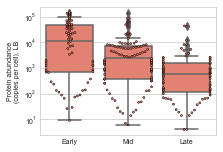

In [28]:
sns.set_style('whitegrid')
#fig = plt.figure(figsize = (58/25.4, 74.5/25.4))
fig = plt.figure(figsize = (80/25.4, 60/25.4))
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.family"] = "Arial"

x_id = 'Class'
y_id = 'Protein_copies_per_cell(Schmidt)'

df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()

plt.tick_params('both', labelsize = 7)

ax = sns.boxplot(x = x_id, y = y_id, data = df_plot,
                 order = ['Early', 'Mid', 'Late'], palette = ['#F37560', '#F37560', '#F37560'])
ax = sns.swarmplot(x = x_id, y = y_id, data = df_plot,
           order = ['Early', 'Mid', 'Late'], palette = ['#F37560', '#F37560', '#F37560'], 
                   dodge=True, s = 2, edgecolor = 'black', linewidth = 0.5)


plt.xlabel('')
plt.ylabel('Protein abundance\n(copies per cell), LB', fontsize = 7)
plt.yscale('log')
plt.tick_params('both', labelsize = 7, length = 0)

plt.savefig('Section 4v10/SuppFig_EGene_stratify-protein_abundance.pdf', type = 'pdf')
plt.savefig('Section 4v10/SuppFig_EGene_stratify-protein_abundance.eps', type = 'eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


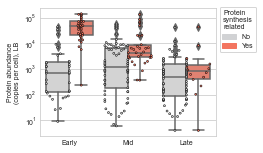

In [29]:
sns.set_style('whitegrid')
#fig = plt.figure(figsize = (58/25.4, 74.5/25.4))
fig = plt.figure(figsize = (80/25.4, 60/25.4))
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.family"] = "Arial"

x_id = 'Class'
y_id = 'Protein_copies_per_cell(Schmidt)'

df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()

plt.tick_params('both', labelsize = 7)

ax = sns.boxplot(x = x_id, y = y_id, data = df_plot, hue = 'Protein synthesis related',
                 order = ['Early', 'Mid', 'Late'], palette = ['lightgray', '#F37560'])
ax = sns.swarmplot(x = x_id, y = y_id, data = df_plot, hue = 'Protein synthesis related',
           order = ['Early', 'Mid', 'Late'], palette = ['lightgray', '#F37560'], 
                   dodge=True, s = 2, edgecolor = 'black', linewidth = 0.5)


plt.xlabel('')
plt.ylabel('Protein abundance\n(copies per cell), LB', fontsize = 7)
plt.tick_params('both', labelsize = 7, length = 0)
plt.yscale('log')

gene_patch = patches.Patch(color = '#F37560', label = 'gene')
promoter_patch = patches.Patch(color = '#D1D2D4', label = 'promoter')
leg = plt.legend([promoter_patch, gene_patch], ['No', 'Yes'], fontsize = 7, loc = 'lower right', frameon = True,
                 title = 'Protein\nsynthesis\nrelated', bbox_to_anchor = (1.25, 0.63))
leg.get_title().set_fontsize('7')

plt.savefig('Section 4v10/SuppFig_EGene_stratify-protein_abundance-hue_ProteinSynthesisRelated.pdf', type = 'pdf')
plt.savefig('Section 4v10/SuppFig_EGene_stratify-protein_abundance-hue_ProteinSynthesisRelated.eps', type = 'eps')

### Stats

In [30]:
df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()
df_plot.dropna(axis = 0, inplace = True)

y_id = 'Protein_copies_per_cell(Schmidt)'

x = df_plot[df_plot['Class'] == 'Early'][y_id]
y = df_plot[df_plot['Class'] == 'Mid'][y_id]
z = df_plot[df_plot['Class'] == 'Late'][y_id]
mannwhitneyu(x,y), mannwhitneyu(x,z), mannwhitneyu(y,z)

(MannwhitneyuResult(statistic=2134.0, pvalue=0.04953464587119565),
 MannwhitneyuResult(statistic=1203.5, pvalue=2.3145008197244297e-06),
 MannwhitneyuResult(statistic=2123.0, pvalue=1.3351406699779389e-06))

In [31]:
df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()
df_plot.dropna(axis = 0, inplace = True)

y_id = 'Protein_copies_per_cell(Schmidt)'

x = df_plot[df_plot['Class'] == 'Early'][y_id]
y = df_plot[df_plot['Class'] == 'Mid'][y_id]
z = df_plot[df_plot['Class'] == 'Late'][y_id]
mean_x = np.mean(x)
mean_y = np.mean(y)
mean_z = np.mean(z)
pooled_var_xy = calc_pooled_var(len(x), np.var(x), len(y), np.var(y))
pooled_var_xz = calc_pooled_var(len(x), np.var(x), len(z), np.var(z))
pooled_var_yz = calc_pooled_var(len(y), np.var(y), len(z), np.var(z))
cohens_d_xy = calc_cohens_d(mean_x, mean_y, pooled_var_xy)
cohens_d_xz = calc_cohens_d(mean_x, mean_z, pooled_var_xz)
cohens_d_yz = calc_cohens_d(mean_y, mean_z, pooled_var_yz)
cohens_d_xy, cohens_d_xz, cohens_d_yz

(0.5249333561297452, 1.0052259503812455, 0.4717666272260888)

## Protein-Protein interactions

### Visualize

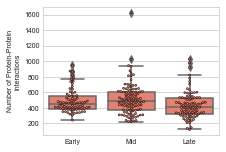

In [32]:
sns.set_style('whitegrid')
#fig = plt.figure(figsize = (58/25.4, 74.5/25.4))
fig = plt.figure(figsize = (80/25.4, 60/25.4))
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.family"] = "Arial"


x_id = 'Class'
y_id = '#P-P_interactions(STRING)'

df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()

plt.tick_params('both', labelsize = 7)

ax = sns.boxplot(x = x_id, y = y_id, data = df_plot,
                 order = ['Early', 'Mid', 'Late'], palette = ['#F37560', '#F37560', '#F37560'])
ax = sns.swarmplot(x = x_id, y = y_id, data = df_plot,
           order = ['Early', 'Mid', 'Late'], palette = ['#F37560', '#F37560', '#F37560'], 
                   dodge=True, s = 2, edgecolor = 'black', linewidth = 0.5)


plt.xlabel('')
plt.ylabel('Number of Protein-Protein\ninteractions', fontsize = 7)
plt.tick_params('both', labelsize = 7, length = 0)

plt.savefig('Section 4v10/SuppFig_EGene_stratify-#PP_interactions.pdf', type = 'pdf')
plt.savefig('Section 4v10/SuppFig_EGene_stratify-#PP_interactions.eps', type = 'eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


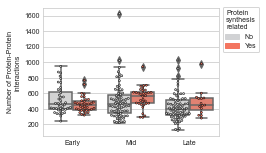

In [33]:
sns.set_style('whitegrid')
#fig = plt.figure(figsize = (58/25.4, 74.5/25.4))
fig = plt.figure(figsize = (80/25.4, 60/25.4))
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.family"] = "Arial"

x_id = 'Class'
y_id = '#P-P_interactions(STRING)'

df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()

plt.tick_params('both', labelsize = 7)

ax = sns.boxplot(x = x_id, y = y_id, data = df_plot, hue = 'Protein synthesis related',
                 order = ['Early', 'Mid', 'Late'], palette = ['lightgray', '#F37560'])
ax = sns.swarmplot(x = x_id, y = y_id, data = df_plot, hue = 'Protein synthesis related',
           order = ['Early', 'Mid', 'Late'], palette = ['lightgray', '#F37560'], 
                   dodge=True, s = 2, edgecolor = 'black', linewidth = 0.5)


plt.xlabel('')
plt.ylabel('Number of Protein-Protein\ninteractions', fontsize = 7)
plt.tick_params('both', labelsize = 7, length = 0)
#plt.yscale('log')

gene_patch = patches.Patch(color = '#F37560', label = 'gene')
promoter_patch = patches.Patch(color = '#D1D2D4', label = 'promoter')
leg = plt.legend([promoter_patch, gene_patch], ['No', 'Yes'], fontsize = 7, loc = 'lower right', frameon = True,
                 title = 'Protein\nsynthesis\nrelated', bbox_to_anchor = (1.25, 0.63))
leg.get_title().set_fontsize('7')

plt.savefig('Section 4v10/SuppFig_EGene_stratify-#PP_interactions-hue_ProteinSynthesisRelated.pdf', type = 'pdf')
plt.savefig('Section 4v10/SuppFig_EGene_stratify-#PP_interactions-hue_ProteinSynthesisRelated.eps', type = 'eps')

### Stats

In [34]:
df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()
df_plot.dropna(axis = 0, inplace = True)

y_id = '#P-P_interactions(STRING)'

x = df_plot[df_plot['Class'] == 'Early'][y_id]
y = df_plot[df_plot['Class'] == 'Mid'][y_id]
z = df_plot[df_plot['Class'] == 'Late'][y_id]
mannwhitneyu(x,y), mannwhitneyu(x,z), mannwhitneyu(y,z)

(MannwhitneyuResult(statistic=2319.0, pvalue=0.181025503850888),
 MannwhitneyuResult(statistic=1913.0, pvalue=0.07440628952565034),
 MannwhitneyuResult(statistic=2913.0, pvalue=0.012253527725227625))

In [35]:
df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()
df_plot.dropna(axis = 0, inplace = True)

y_id = '#P-P_interactions(STRING)'

x = df_plot[df_plot['Class'] == 'Early'][y_id]
y = df_plot[df_plot['Class'] == 'Mid'][y_id]
z = df_plot[df_plot['Class'] == 'Late'][y_id]
mean_x = np.mean(x)
mean_y = np.mean(y)
mean_z = np.mean(z)
pooled_var_xy = calc_pooled_var(len(x), np.var(x), len(y), np.var(y))
pooled_var_xz = calc_pooled_var(len(x), np.var(x), len(z), np.var(z))
pooled_var_yz = calc_pooled_var(len(y), np.var(y), len(z), np.var(z))
cohens_d_xy = calc_cohens_d(mean_x, mean_y, pooled_var_xy)
cohens_d_xz = calc_cohens_d(mean_x, mean_z, pooled_var_xz)
cohens_d_yz = calc_cohens_d(mean_y, mean_z, pooled_var_yz)
cohens_d_xy, cohens_d_xz, cohens_d_yz

(0.1579011574320999, 0.20959006582191744, 0.33155562343019385)

## RNA abundance

### Visualize

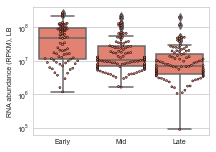

In [36]:
sns.set_style('whitegrid')
#fig = plt.figure(figsize = (58/25.4, 74.5/25.4))
fig = plt.figure(figsize = (80/25.4, 60/25.4))
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.family"] = "Arial"


x_id = 'Class'
y_id = 'RNA_RPKM_t0_avg(Venturelli)'

df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()

plt.tick_params('both', labelsize = 7)

ax = sns.boxplot(x = x_id, y = y_id, data = df_plot,
                 order = ['Early', 'Mid', 'Late'], palette = ['#F37560', '#F37560', '#F37560'])
ax = sns.swarmplot(x = x_id, y = y_id, data = df_plot,
           order = ['Early', 'Mid', 'Late'], palette = ['#F37560', '#F37560', '#F37560'], 
                   dodge=True, s = 2, edgecolor = 'black', linewidth = 0.5)


plt.xlabel('')
plt.ylabel('RNA abundance (RPKM), LB', fontsize = 7)
plt.tick_params('both', labelsize = 7, length = 0)
plt.yscale('log')

plt.savefig('Section 4v10/SuppFig_EGene_stratify-RNA_abundance.pdf', type = 'pdf')
plt.savefig('Section 4v10/SuppFig_EGene_stratify-RNA_abundance.eps', type = 'eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


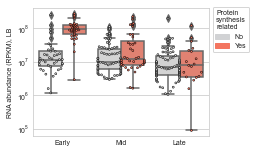

In [37]:
sns.set_style('whitegrid')
#fig = plt.figure(figsize = (58/25.4, 74.5/25.4))
fig = plt.figure(figsize = (80/25.4, 60/25.4))
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.family"] = "Arial"

x_id = 'Class'
y_id = 'RNA_RPKM_t0_avg(Venturelli)'

df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()

plt.tick_params('both', labelsize = 7)

ax = sns.boxplot(x = x_id, y = y_id, data = df_plot, hue = 'Protein synthesis related',
                 order = ['Early', 'Mid', 'Late'], palette = ['lightgray', '#F37560'])
ax = sns.swarmplot(x = x_id, y = y_id, data = df_plot, hue = 'Protein synthesis related',
           order = ['Early', 'Mid', 'Late'], palette = ['lightgray', '#F37560'], 
                   dodge=True, s = 2, edgecolor = 'black', linewidth = 0.5)


plt.xlabel('')
plt.ylabel('RNA abundance (RPKM), LB', fontsize = 7)
plt.tick_params('both', labelsize = 7, length = 0)
plt.yscale('log')

gene_patch = patches.Patch(color = '#F37560', label = 'gene')
promoter_patch = patches.Patch(color = '#D1D2D4', label = 'promoter')
leg = plt.legend([promoter_patch, gene_patch], ['No', 'Yes'], fontsize = 7, loc = 'lower right', frameon = True,
                 title = 'Protein\nsynthesis\nrelated', bbox_to_anchor = (1.25, 0.63))
leg.get_title().set_fontsize('7')

plt.savefig('Section 4v10/SuppFig_EGene_stratify-RNA_abundance-hue_ProteinSynthesisRelated.pdf', type = 'pdf')
plt.savefig('Section 4v10/SuppFig_EGene_stratify-RNA_abundance-hue_ProteinSynthesisRelated.eps', type = 'eps')

### Stats

In [38]:
df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()
df_plot.dropna(axis = 0, inplace = True)

y_id = 'RNA_RPKM_t0_avg(Venturelli)'

x = df_plot[df_plot['Class'] == 'Early'][y_id]
y = df_plot[df_plot['Class'] == 'Mid'][y_id]
z = df_plot[df_plot['Class'] == 'Late'][y_id]
mannwhitneyu(x,y), mannwhitneyu(x,z), mannwhitneyu(y,z)

(MannwhitneyuResult(statistic=1721.0, pvalue=0.0004890275154983667),
 MannwhitneyuResult(statistic=998.0, pvalue=2.0146061521759448e-08),
 MannwhitneyuResult(statistic=2451.0, pvalue=0.00011695811567232693))

In [39]:
df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()
df_plot.dropna(axis = 0, inplace = True)

y_id = 'RNA_RPKM_t0_avg(Venturelli)'

x = df_plot[df_plot['Class'] == 'Early'][y_id]
y = df_plot[df_plot['Class'] == 'Mid'][y_id]
z = df_plot[df_plot['Class'] == 'Late'][y_id]
mean_x = np.mean(x)
mean_y = np.mean(y)
mean_z = np.mean(z)
pooled_var_xy = calc_pooled_var(len(x), np.var(x), len(y), np.var(y))
pooled_var_xz = calc_pooled_var(len(x), np.var(x), len(z), np.var(z))
pooled_var_yz = calc_pooled_var(len(y), np.var(y), len(z), np.var(z))
cohens_d_xy = calc_cohens_d(mean_x, mean_y, pooled_var_xy)
cohens_d_xz = calc_cohens_d(mean_x, mean_z, pooled_var_xz)
cohens_d_yz = calc_cohens_d(mean_y, mean_z, pooled_var_yz)
cohens_d_xy, cohens_d_xz, cohens_d_yz

(0.6669504336319926, 1.0432034454846018, 0.3772857577118342)

## RNA half-life

### Visualize

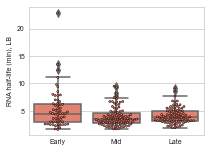

In [40]:
sns.set_style('whitegrid')
#fig = plt.figure(figsize = (58/25.4, 74.5/25.4))
fig = plt.figure(figsize = (80/25.4, 60/25.4))
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.family"] = "Arial"


x_id = 'Class'
y_id = 'RNA_half-life(min)_LB(Bernstein)'

df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()

plt.tick_params('both', labelsize = 7)

ax = sns.boxplot(x = x_id, y = y_id, data = df_plot,
                 order = ['Early', 'Mid', 'Late'], palette = ['#F37560', '#F37560', '#F37560'])
ax = sns.swarmplot(x = x_id, y = y_id, data = df_plot,
           order = ['Early', 'Mid', 'Late'], palette = ['#F37560', '#F37560', '#F37560'], 
                   dodge=True, s = 2, edgecolor = 'black', linewidth = 0.5)


plt.xlabel('')
plt.ylabel('RNA half-life (min), LB', fontsize = 7)
plt.tick_params('both', labelsize = 7, length = 0)

plt.savefig('Section 4v10/SuppFig_EGene_stratify-RNA_half_life.pdf', type = 'pdf')
plt.savefig('Section 4v10/SuppFig_EGene_stratify-RNA_half_life.eps', type = 'eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


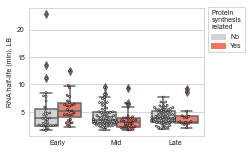

In [41]:
sns.set_style('whitegrid')
#fig = plt.figure(figsize = (58/25.4, 74.5/25.4))
fig = plt.figure(figsize = (80/25.4, 60/25.4))
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.family"] = "Arial"

x_id = 'Class'
y_id = 'RNA_half-life(min)_LB(Bernstein)'

df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()

plt.tick_params('both', labelsize = 7)

ax = sns.boxplot(x = x_id, y = y_id, data = df_plot, hue = 'Protein synthesis related',
                 order = ['Early', 'Mid', 'Late'], palette = ['lightgray', '#F37560'])
ax = sns.swarmplot(x = x_id, y = y_id, data = df_plot, hue = 'Protein synthesis related',
           order = ['Early', 'Mid', 'Late'], palette = ['lightgray', '#F37560'], 
                   dodge=True, s = 2, edgecolor = 'black', linewidth = 0.5)


plt.xlabel('')
plt.ylabel('RNA half-life (min), LB', fontsize = 7)
plt.tick_params('both', labelsize = 7, length = 0)
#plt.yscale('log')

gene_patch = patches.Patch(color = '#F37560', label = 'gene')
promoter_patch = patches.Patch(color = '#D1D2D4', label = 'promoter')
leg = plt.legend([promoter_patch, gene_patch], ['No', 'Yes'], fontsize = 7, loc = 'lower right', frameon = True,
                 title = 'Protein\nsynthesis\nrelated', bbox_to_anchor = (1.25, 0.63))
leg.get_title().set_fontsize('7')

plt.savefig('Section 4v10/SuppFig_EGene_stratify-RNA_half_life-hue_ProteinSynthesisRelated.pdf', type = 'pdf')
plt.savefig('Section 4v10/SuppFig_EGene_stratify-RNA_half_life-hue_ProteinSynthesisRelated.eps', type = 'eps')

### Stats

In [42]:
df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()
df_plot.dropna(axis = 0, inplace = True)

y_id = 'RNA_half-life(min)_LB(Bernstein)'

x = df_plot[df_plot['Class'] == 'Early'][y_id]
y = df_plot[df_plot['Class'] == 'Mid'][y_id]
z = df_plot[df_plot['Class'] == 'Late'][y_id]
mannwhitneyu(x,y), mannwhitneyu(x,z), mannwhitneyu(y,z)

(MannwhitneyuResult(statistic=1917.5, pvalue=0.005972658393332531),
 MannwhitneyuResult(statistic=1914.0, pvalue=0.07496648877536548),
 MannwhitneyuResult(statistic=3067.5, pvalue=0.038244844109384855))

In [43]:
df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()
df_plot.dropna(axis = 0, inplace = True)

y_id = 'RNA_half-life(min)_LB(Bernstein)'

x = df_plot[df_plot['Class'] == 'Early'][y_id]
y = df_plot[df_plot['Class'] == 'Mid'][y_id]
z = df_plot[df_plot['Class'] == 'Late'][y_id]
mean_x = np.mean(x)
mean_y = np.mean(y)
mean_z = np.mean(z)
pooled_var_xy = calc_pooled_var(len(x), np.var(x), len(y), np.var(y))
pooled_var_xz = calc_pooled_var(len(x), np.var(x), len(z), np.var(z))
pooled_var_yz = calc_pooled_var(len(y), np.var(y), len(z), np.var(z))
cohens_d_xy = calc_cohens_d(mean_x, mean_y, pooled_var_xy)
cohens_d_xz = calc_cohens_d(mean_x, mean_z, pooled_var_xz)
cohens_d_yz = calc_cohens_d(mean_y, mean_z, pooled_var_yz)
cohens_d_xy, cohens_d_xz, cohens_d_yz

(0.5430682115384221, 0.43541926040609913, 0.16204823845531036)

## Distance from ori

### Visualize

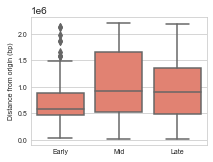

In [44]:
sns.set_style('whitegrid')
#fig = plt.figure(figsize = (58/25.4, 74.5/25.4))
fig = plt.figure(figsize = (80/25.4, 60/25.4))
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.family"] = "Arial"


x_id = 'Class'
y_id = 'dist_from_ori'

df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()

plt.tick_params('both', labelsize = 7)

ax = sns.boxplot(x = x_id, y = y_id, data = df_plot,
                 order = ['Early', 'Mid', 'Late'], palette = ['#F37560', '#F37560', '#F37560'])
#ax = sns.swarmplot(x = x_id, y = y_id, data = df_plot,
#           order = ['Early', 'Mid', 'Late'], palette = ['#F37560', '#F37560', '#F37560'], 
#                   dodge=True, s = 2, edgecolor = 'black', linewidth = 0.5)


plt.xlabel('')
plt.ylabel('Distance from origin (bp)', fontsize = 7)
plt.tick_params('both', labelsize = 7, length = 0)

plt.savefig('Section 4v10/SuppFig_EGene_stratify-dis_from_ori.pdf', type = 'pdf')
plt.savefig('Section 4v10/SuppFig_EGene_stratify-dis_from_ori.eps', type = 'eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


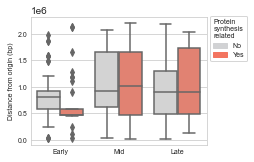

In [45]:
sns.set_style('whitegrid')
#fig = plt.figure(figsize = (58/25.4, 74.5/25.4))
fig = plt.figure(figsize = (80/25.4, 60/25.4))
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.family"] = "Arial"

x_id = 'Class'
y_id = 'dist_from_ori'

df_plot = df_df_KDcols_gpby_AvgLR_km3f_selcols.copy()

plt.tick_params('both', labelsize = 7)

ax = sns.boxplot(x = x_id, y = y_id, data = df_plot, hue = 'Protein synthesis related',
                 order = ['Early', 'Mid', 'Late'], palette = ['lightgray', '#F37560'])
#ax = sns.swarmplot(x = x_id, y = y_id, data = df_plot, hue = 'Protein synthesis related',
#           order = ['Early', 'Mid', 'Late'], palette = ['lightgray', '#F37560'], 
#                   dodge=True, s = 2, edgecolor = 'black', linewidth = 0.5)


plt.xlabel('')
plt.ylabel('Distance from origin (bp)', fontsize = 7)
plt.tick_params('both', labelsize = 7, length = 0)
#plt.yscale('log')

gene_patch = patches.Patch(color = '#F37560', label = 'gene')
promoter_patch = patches.Patch(color = '#D1D2D4', label = 'promoter')
leg = plt.legend([promoter_patch, gene_patch], ['No', 'Yes'], fontsize = 7, loc = 'lower right', frameon = True,
                 title = 'Protein\nsynthesis\nrelated', bbox_to_anchor = (1.25, 0.63))
leg.get_title().set_fontsize('7')

plt.savefig('Section 4v10/SuppFig_EGene_stratify-dis_from_ori-hue_ProteinSynthesisRelated.pdf', type = 'pdf')
plt.savefig('Section 4v10/SuppFig_EGene_stratify-dis_from_ori-hue_ProteinSynthesisRelated.eps', type = 'eps')